In [3]:
import pandas as pd
splits = {'train': 'yelp_review_full/train-00000-of-00001.parquet', 'test': 'yelp_review_full/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])
testdf = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["test"])

In [2]:
print(df)

        label                                               text
0           4  dr. goldberg offers everything i look for in a...
1           1  Unfortunately, the frustration of being Dr. Go...
2           3  Been going to Dr. Goldberg for over 10 years. ...
3           3  Got a letter in the mail last week that said D...
4           0  I don't know what Dr. Goldberg was like before...
...       ...                                                ...
649995      4  I had a sprinkler that was gushing... pipe bro...
649996      0  Phone calls always go to voicemail and message...
649997      0  Looks like all of the good reviews have gone t...
649998      4  I was able to once again rely on Yelp to provi...
649999      0  I have been using this company for 11 months. ...

[650000 rows x 2 columns]


In [4]:
print(testdf)

       label                                               text
0          0  I got 'new' tires from them and within two wee...
1          0  Don't waste your time.  We had two different p...
2          0  All I can say is the worst! We were the only 2...
3          0  I have been to this restaurant twice and was d...
4          0  Food was NOT GOOD at all! My husband & I ate h...
...      ...                                                ...
49995      0  Just wanted to write a review to chip in with ...
49996      4  Great ambience. Great drinks. Great food. I lo...
49997      3  I have been to the other Monks locations so I ...
49998      1  Don't go here.  I know you might want to try i...
49999      0  Buffet was recently open after renovation so m...

[50000 rows x 2 columns]


Exploratary Data Analysis

In [5]:
# Display basic information about the dataset
df.info()

# Check for missing values
df.isnull().sum()

# Display summary statistics
df.describe()

# Check the first few rows of the dataset
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   650000 non-null  int64 
 1   text    650000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.9+ MB


,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64


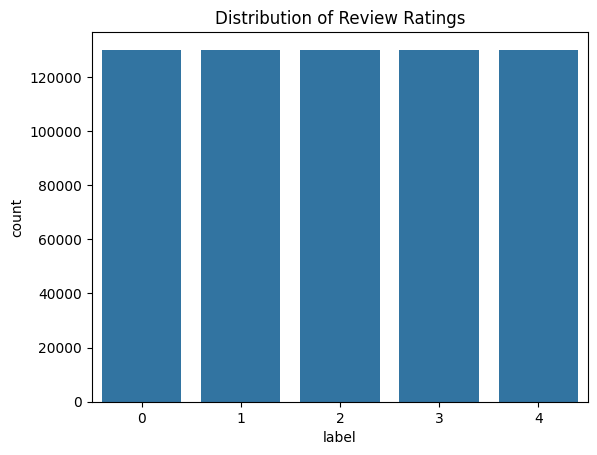

In [6]:
# Check the distribution of the labels (assuming there's a 'label' column)
label_distribution = df['label'].value_counts()
print(label_distribution)

# Visualize the distribution of labels
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.title('Distribution of Review Ratings')
plt.show()


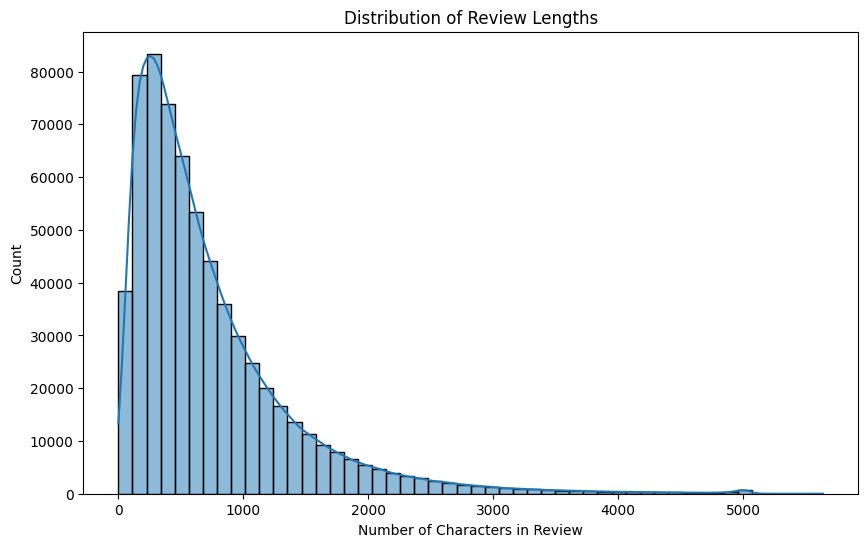

Shortest review:
 A

Longest review:
 Pour le jour de l'an 2010, nous \u00e9tions a Edinburgh, la neige \u00e9tait au rendez-vous ainsi que le froid glacial.\n\n\n Le sapin (voir photo) vient du grand magasin \u00e0 5 ou 6 \u00e9tage, Jenners (on y trouve de tout, je vous invite \u00e0 gouter a leur restauration).\n\n\n L'\u00e9cureuil, je l'ai rencontre dans le jardin de \"Princes Street Gardens\" jour de l'an.\n\n\n Et pour les 12 coups de minuits, nous avons assist\u00e9 au concert du groupe qui a donn\u00e9 naissance au Ska, Madness. Dans le jardin sit\u00e9 pr\u00e9c\u00e9demment. Je vais vous racont\u00e9 notre incroyable chance au cours de la nuit de Hogmanay. Cette nuit l\u00e0, \u00e9tait le dernier jour de l'ann\u00e9e et en \u00e9cossais cela s'appelle Hogmanay.\n\n\n Un petit aper\u00e7u en vid\u00e9o : http://vimeo.com/9888642 \n\n\n Pour c\u00e9l\u00e9brer cette f\u00eate, la ville d'Edinburgh et plus particuli\u00e8rement une partie de Princes Street ainsi que le jardin 

In [7]:
# Display the length of reviews to understand the distribution
df['review_length'] = df['text'].apply(len)

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters in Review')
plt.show()

# Display some of the shortest and longest reviews
print("Shortest review:\n", df.loc[df['review_length'].idxmin()]['text'])
print("\nLongest review:\n", df.loc[df['review_length'].idxmax()]['text'])


Data Preprocessing

In [8]:
# Check for missing values
df.isnull().sum()

# Drop rows with missing values, if any
df = df.dropna()


In [9]:
import re

# Function to clean text data
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove unwanted characters (non-alphanumeric characters)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the clean_text function to the text column
df['cleaned_text'] = df['text'].apply(clean_text)


Sample of tokenisation

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download stopwords from nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Function to tokenize text and remove stopwords
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply the tokenize_text function
df['tokens'] = df['cleaned_text'].apply(tokenize_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Creation of bert model

In [11]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = BertModel(config)
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [12]:
bert_config = BertConfig(
    hidden_size=768,
    intermediate_size=3072,
    max_position_embeddings=512,
    num_attention_heads=12,
    num_hidden_layers=12
)

In [14]:
from transformers import BertConfig, BertModel

config = BertConfig()
model = BertModel(config)

from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Load pre-trained BERT tokenizer

In [15]:
import pandas as pd
import torch
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset


In [22]:
# Load a subset of the dataset to speed up processing
def load_subset(file_path, num_samples):
    df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])
    return df.sample(n=num_samples, random_state=42)  # Sample a subset of data



In [23]:
# Load and preprocess the dataset
def preprocess_data(df):
    sentences = df['text'].tolist()
    labels = df['label'].tolist()

    # Load pre-trained BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize and prepare input data
    encoded_inputs = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    input_ids = encoded_inputs['input_ids']
    attention_masks = encoded_inputs['attention_mask']
    labels_tensor = torch.tensor(labels)

    return input_ids, attention_masks, labels_tensor


In [24]:
# Define file paths and subset size
train_file_path = 'yelp_review_full/train-00000-of-00001.parquet'
test_file_path = 'yelp_review_full/test-00000-of-00001.parquet'
subset_size = 1000  # Use a smaller subset for faster processing

# Load and preprocess datasets
train_df = load_subset(train_file_path, subset_size)
test_df = load_subset(test_file_path, subset_size)

train_input_ids, train_attention_masks, train_labels_tensor = preprocess_data(train_df)
test_input_ids, test_attention_masks, test_labels_tensor = preprocess_data(test_df)

# Create TensorDataset and DataLoader
def create_dataloader(input_ids, attention_masks, labels, batch_size=16):
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_dataloader = create_dataloader(train_input_ids, train_attention_masks, train_labels_tensor)
test_dataloader = create_dataloader(test_input_ids, test_attention_masks, test_labels_tensor)

# Example: Iterate over a single batch
for batch in train_dataloader:
    input_ids_batch, attention_masks_batch, labels_batch = batch
    print("Batch Input IDs:\n", input_ids_batch)
    print("\nBatch Attention Masks:\n", attention_masks_batch)
    print("\nBatch Labels:\n", labels_batch)
    break  # Only showing the first batch for brevity


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Batch Input IDs:
 tensor([[  101,  1045,  2123,  ...,  2000,  3046,   102],
        [  101,  1045,  2018,  ...,     0,     0,     0],
        [  101,  2241,  2006,  ...,  2002,  2649,   102],
        ...,
        [  101,  1045,  3985,  ...,     0,     0,     0],
        [  101,  5409,  3325,  ...,     0,     0,     0],
        [  101,  1045,  2123,  ...,  3180, 22201,   102]])

Batch Attention Masks:
 tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])

Batch Labels:
 tensor([3, 3, 1, 0, 3, 0, 3, 2, 2, 1, 2, 4, 4, 0, 0, 2])


To check the accuracy of the model

In [25]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [26]:
# Ensure labels are binary
train_df['label'] = train_df['label'].apply(lambda x: 0 if x < 1 else 1)
test_df['label'] = test_df['label'].apply(lambda x: 0 if x < 1 else 1)

# Prepare data
train_input_ids, train_attention_masks, train_labels = preprocess_data(train_df)
test_input_ids, test_attention_masks, test_labels = preprocess_data(test_df)

# Create DataLoader
def create_dataloader(input_ids, attention_masks, labels, batch_size=16):
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_dataloader = create_dataloader(train_input_ids, train_attention_masks, train_labels)
test_dataloader = create_dataloader(test_input_ids, test_attention_masks, test_labels)

# Initialize model, optimizer, and scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)  # Use 3 epochs

# Training loop
for epoch in range(3):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_masks, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/3, Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
total_correct = 0
total_count = 0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_masks, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_masks)
        predictions = torch.argmax(outputs.logits, dim=-1)
        total_correct += (predictions == labels).sum().item()
        total_count += labels.size(0)
accuracy = total_correct / total_count
print(f"Test Accuracy: {accuracy:.4f}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Loss: 0.4541
Epoch 2/3, Loss: 0.2888
Epoch 3/3, Loss: 0.1811
Test Accuracy: 0.9740
